In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Embedding, Dense, Dropout, LSTM, Input, Concatenate
#from keras import Sequential
#from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, Dropout, Bidirectional, LSTM
#from keras.layers import  CuDNNLSTM
#from keras.layers.merge import concatenate

In [2]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [3]:
df = pd.read_csv('C:/Users/Donghyeok/Desktop/Work Folder/Reddit Sarcasm Detection/train-balanced-sarcasm.csv')

In [4]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
df1 = df.dropna(subset=['comment'])
df1

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [6]:
df1['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [7]:
comments = df1['comment']
labels = df1['label']
parent_comments = df1['parent_comment']
subreddit = df1['subreddit']
score = df1['score']
ups = df1['ups']
downs = df1['downs']

In [8]:
def tokenize_text(lines, num_words = None):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(lines)
    return tokenizer
    
def max_length(lines):
    return max([len(s.split()) for s in lines])

def pad_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post', truncating='post')
    return padded

In [10]:
sample_df_idx1 = np.random.choice(df1.loc[df1['label']==0].index, int(len(df1.loc[df1['label']==0].index)*0.5))
sample_df_idx2 = np.random.choice(df1.loc[df1['label']==1].index, int(len(df1.loc[df1['label']==1].index)*0.5))

In [11]:
sample_df_idx = np.concatenate((sample_df_idx1, sample_df_idx2))

In [12]:
sample_df = df1.loc[sample_df_idx]
sample_comments = comments.loc[sample_df_idx]
sample_labels = labels.loc[sample_df_idx]
sample_parent_comments = parent_comments.loc[sample_df_idx]
sample_subreddit = subreddit.loc[sample_df_idx]
sample_score = score.loc[sample_df_idx]
sample_ups = ups.loc[sample_df_idx]
sample_downs = downs.loc[sample_df_idx]

In [13]:
embedding_dim = 16
vocab_size = 8000

tokenized_comments = tokenize_text(sample_comments, vocab_size)
length = max_length(sample_comments)
main_vocab_size = len(tokenized_comments.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

tokenized_parent_comments = tokenize_text(sample_parent_comments, vocab_size)
parent_length = max_length(parent_comments)
parent_vocab_size = len(tokenized_parent_comments.word_index) + 1
print('PC Max document length: %d' % parent_length)
print('PC Vocabulary size: %d' % parent_vocab_size)

Max document length: 1818
Vocabulary size: 8000
PC Max document length: 4198
PC Vocabulary size: 156332


In [14]:
length = 100

In [15]:
#mask = np.random.rand(len(sample_df)) < 0.8
train_data = sample_comments # [mask]
train_labels = sample_labels # [mask]
#test_data = sample_comments[~mask]
#test_labels = sample_labels[~mask]

train_padded = pad_text(tokenized_comments, train_data, length)
# test_padded = pad_text(tokenized_comments, test_data, length)

In [16]:
train_padded = np.array(train_padded)
#test_padded = np.array(test_padded)
print(train_padded.shape)
#print(test_padded.shape)

#labels processing
train_labels = np.array(train_labels)
#test_labels = np.array(test_labels)
print(train_labels.shape)
#print(test_labels.shape)

(505386, 100)
(505386,)


In [17]:
# First checking if GPU is available
train_on_gpu=tf.test.is_gpu_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded, train_labels))

In [20]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    tf.print("Execution time:", time.perf_counter() - start_time)

In [42]:
train_dataset

<TensorSliceDataset shapes: ((100,), ()), types: (tf.int32, tf.int64)>

In [40]:
benchmark(train_dataset)

KeyboardInterrupt: 

In [ ]:
benchmark(
    train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(train_dataset)
)

In [ ]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        train_dataset,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

In [19]:
# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix],
#                                                input_length=MAX_SEQUENCE_LENGTH, trainable=False)

# x = embedding_layer(sequence_input)
# x = Dropout(0.3)(x)
# x = LSTM(100)(x)
# prob = Dense(1, activation='sigmoid')(x)

# model = Model(sequence_input, prob)
# model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [20]:
# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim, input_length=length))
# model.add(LSTM(256))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=length))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 169,601
Trainable params: 169,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10
batch_size = 256

lstm = model.fit(train_padded, train_labels, epochs=num_epochs, batch_size=batch_size, validation_split=0.3, verbose=1)

In [ ]:
plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()
  
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [24]:
predictions = model.predict(test_padded)

In [28]:
y_pred = predictions > 0.5

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [33]:
matrix = confusion_matrix(test_labels, y_pred)

In [40]:
tn, fp, fn, tp = matrix.ravel()

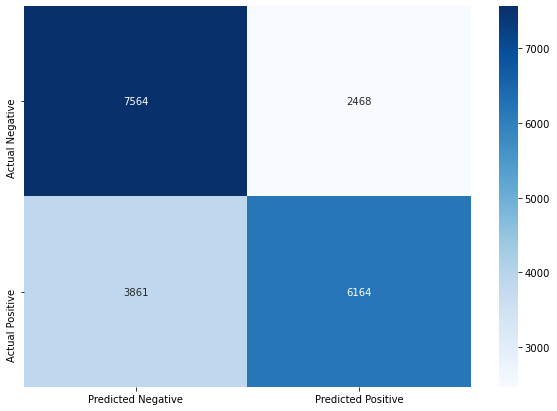

In [50]:
df_cm = pd.DataFrame(matrix, index = ["Actual Negative", "Actual Positive"],
                      columns = ["Predicted Negative", "Predicted Positive"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")